<h2>Creating a Kaggle workflow </h2>

The purpose of this project is to build a workflow that will help us produce better and faster solutions to a kaggle challenge. In this case the Titanic Challeng 

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

%matplotlib inline

In [6]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [46]:
holdout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<h3>Data cleanup</h3>

Load all the functions we created previously

In [7]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(df["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [8]:
def clean_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    col_list = ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for col in col_list:
        df = create_dummies(df,col)
    return df    

In [9]:
clean_train = clean_df(train)
clean_holdout = clean_df(holdout)

In [50]:
clean_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,23.699966,0.523008,0.381594,32.204208,0.198653,0.049383,0.028058,...,0.052750,0.066218,0.037037,0.035915,0.014590,0.004489,0.001122,0.771044,0.352413,0.647587
std,257.353842,0.486592,0.836071,17.731181,1.102743,0.806057,49.693429,0.399210,0.216787,0.165232,...,0.223659,0.248802,0.188959,0.186182,0.119973,0.066890,0.033501,0.420397,0.477990,0.477990
min,1.000000,0.000000,1.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<H3> Data Exploration</h3>

First lets check the SibSp (number of siblings or spouse onboard) and Parch (Number of parents or children onboard) columns

In [51]:
clean_train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [52]:
clean_train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

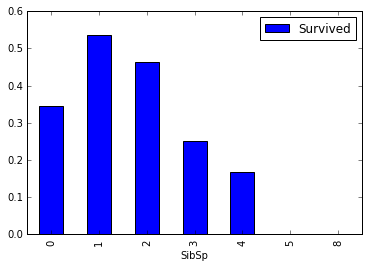

In [53]:
sibsp_pivot = clean_train.pivot_table(index='SibSp',values='Survived')
sibsp_pivot.plot.bar()
plt.show()

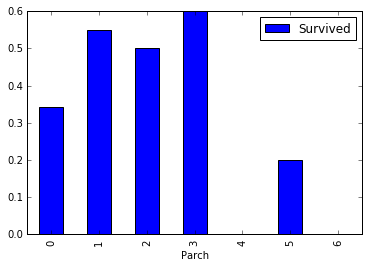

In [54]:
parch_pivot = clean_train.pivot_table(index='Parch',values='Survived')
parch_pivot.plot.bar()
plt.show()

Lets combine these 2 columns togther to see if it has more affect on the outcome

In [10]:
clean_train['tot_family'] = clean_train['SibSp'] + clean_train['Parch']
clean_holdout['tot_family'] = clean_holdout['SibSp'] + clean_holdout['Parch']

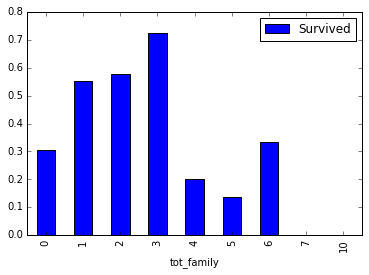

In [11]:
family_pivot = clean_train.pivot_table(index='tot_family',values='Survived')
family_pivot.plot.bar()
plt.show()

so it looks like having a family onboard with you increases the chances of surviving since ony 30% of those with no family survived. Having said that, it is not a linear relationship so we might consider building this feature in a different way instead of total number of family memebers

In [12]:
def isalone(df):
    df["isalone"] = 0
    df.loc[(df["tot_family"] == 0),"isalone"] = 1
    df = df.drop("tot_family",axis=1)
    return df    
        
clean_train = isalone(clean_train)
clean_holdout = isalone(clean_holdout)

<h3>Features Selection </h3>

In [14]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns to use:" )
    print(best_columns)
    
    
    return best_columns
    

In [15]:
features = select_features(clean_train)

Best Columns to use:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



<h3>Model Selection </h3>

This function will iterate over a few options of models nd parameters and will check which one works best

In [60]:
def select_model(df,features):
    model_parameters =[ {"name":"LogisticRegression",
                         "estimator":LogisticRegression(),
                         "hyperparameters":
                            {"solver":["newton-cg", "lbfgs", "liblinear"]

                            }
                        }, 

                        {
                        "name": "KNeighborsClassifier",
                        "estimator": KNeighborsClassifier(),
                        "hyperparameters":
                            {
                                "n_neighbors": range(1,20,2),
                                "weights": ["distance", "uniform"],
                                "algorithm": ["ball_tree", "kd_tree", "brute"],
                                "p": [1,2]
                            }
                        },
                       {"name": "RandomForestClassifier",
                        "estimator": RandomForestClassifier(),
                        "hyperparameters":
                            {"n_estimators": [4,6,9],
                             "criterion": ["entropy", "gini"],
                             "max_depth": [2,5,10],
                             "max_features": ["log2","sqrt"],
                             "min_samples_leaf": [1,5,8],
                             "min_samples_split": [2, 3, 5]
                            }
                       }


                       ]
   
    
    all_x = df[features]
    all_y = df['Survived']
    for model_name in model_parameters:
        model = model_name['estimator']
        hyperparameters = model_name['hyperparameters']
        grid = GridSearchCV(model,param_grid=hyperparameters,cv=10)
        grid.fit(all_x,all_y)
        model_name['best_params'] = grid.best_params_
        model_name['best_score'] = grid.best_score_
        model_name["best_model"] = grid.best_estimator_
        print("Name: {}".format(model_name['name']) )
        print("Best Params: {}".format(grid.best_params_)) 
        print("Best Score: {}".format(grid.best_score_))
    return model_parameters
    

In [61]:
model_list = select_model(clean_train,features)

Name: LogisticRegression
Best Params: {'solver': 'liblinear'}
Best Score: 0.8204264870931538
Name: KNeighborsClassifier
Best Params: {'n_neighbors': 5, 'weights': 'uniform', 'algorithm': 'brute', 'p': 1}
Best Score: 0.7755331088664422
Name: RandomForestClassifier
Best Params: {'min_samples_leaf': 5, 'min_samples_split': 2, 'criterion': 'entropy', 'n_estimators': 6, 'max_depth': 10, 'max_features': 'sqrt'}
Best Score: 0.835016835016835


<h3>Training final model and create a submission file</h3>

In [62]:
def save_submission_file(trained_model,features,file_name="submission.csv"):
    predictions = trained_model.predict(clean_holdout[features])
    submission = pd.DataFrame()
    submission['PassengerId'] = clean_holdout['PassengerId']
    submission['Survived'] = predictions
    submission.to_csv(file_name,index=False)
    

In [63]:
best_rfc = model_list[2]['best_model']
save_submission_file(best_rfc,features)

The score I got from Kaggle was 0.75598 so I am going to try and remove some of the collinearity (columns that have too similar values) since it might be causing overfitting issues

<h3> Second try - Removing Colinear columns </h3>

In [16]:
features2 = ['Pclass', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'isalone']

In [65]:
model_list2 = select_model(clean_train,features2)

Name: LogisticRegression
Best Params: {'solver': 'newton-cg'}
Best Score: 0.8058361391694725
Name: KNeighborsClassifier
Best Params: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 2}
Best Score: 0.8125701459034792
Name: RandomForestClassifier
Best Params: {'min_samples_leaf': 1, 'min_samples_split': 5, 'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 10, 'max_features': 'log2'}
Best Score: 0.8170594837261503


In [66]:
best_rfc2 = model_list2[2]['best_model']
save_submission_file(best_rfc,features)

This produced the exact same score as the first try

In [68]:
best_rfc3 = model_list2[1]['best_model']
save_submission_file(best_rfc,features,"Sub3.csv")

This attempt produced a higher score of 0.7799

<H3> Experimenting with more models</h3>

In order to save the previous results I will copt the select_model funtion, rename it and change some of the things:

In [33]:
def select_model2(df,features):
    model_parameters2 =[ {"name":"Perceptron",
                         "estimator":Perceptron(),
                         "hyperparameters":
                         {"alpha": [0.0001,0.0002] }
                        }, 

                        {
                        "name": "SGDClassifier",
                        "estimator": SGDClassifier(),
                        "hyperparameters":
                            {  }
                        },
                       {"name": "SVC",
                        "estimator": SVC(),
                        "hyperparameters":
                            {}
                       },
                        {"name": "DecisionTreeClassifier",
                         "estimator": DecisionTreeClassifier(),
                         "hyperparameters":
                            {  }
                            
                        }


                       ]
   
    
    all_x = df[features]
    all_y = df['Survived']
    for model_name in model_parameters2:
        model = model_name['estimator']
        hyperparameters = model_name['hyperparameters']
        grid = GridSearchCV(model,param_grid=hyperparameters,cv=10)
        grid.fit(all_x,all_y)
        model_name['best_params'] = grid.best_params_
        model_name['best_score'] = grid.best_score_
        model_name["best_model"] = grid.best_estimator_
        print("Name: {}".format(model_name['name']) )
        print("Best Params: {}".format(grid.best_params_)) 
        print("Best Score: {}".format(grid.best_score_))
    return model_parameters2

In [34]:
model_list = select_model2(clean_train,features2)

Name: Perceptron
Best Params: {'alpha': 0.0001}
Best Score: 0.6419753086419753
Name: SGDClassifier
Best Params: {}
Best Score: 0.6576879910213244
Name: SVC
Best Params: {}
Best Score: 0.7878787878787878
Name: DecisionTreeClassifier
Best Params: {}
Best Score: 0.8024691358024691


We can see the scores are lower in these models so we will skip them